# Week 9 Notebook: Select the Winning Model
The goal of this week's assignment is to evaluate all 9 models against a validation dataset, select the best-performing model and predict how well the selected model will perform on unseen data in production (i.e., your test data).

 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pickle


### Read data as dataframe

In [2]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

model_folder = os.path.join(parent_dir,"models")
data_folder = os.path.join(parent_dir,"data")

raw_data_folder = os.path.join(data_folder,"raw")
interim_data_folder = os.path.join(data_folder,"interim")
processed_data_folder = os.path.join(data_folder, "processed")

In [3]:
# Paths for feature variables
X_train_scaled_path = os.path.join(processed_data_folder, 'X_train_scaled.parquet')
X_val_scaled_path = os.path.join(processed_data_folder, 'X_val_scaled.parquet')
X_test_scaled_path = os.path.join(processed_data_folder, 'X_test_scaled.parquet')

train_pca_path = os.path.join(processed_data_folder, 'X_train_pca.parquet')
val_pca_path = os.path.join(processed_data_folder, 'X_val_pca.parquet')
test_pca_path = os.path.join(processed_data_folder, 'X_test_pca.parquet')

X_train_poly_path = os.path.join(processed_data_folder, "X_train_poly.parquet")
X_val_poly_path = os.path.join(processed_data_folder, "X_val_poly.parquet")

# Paths for the target variables
y_train_path = os.path.join(processed_data_folder, 'y_train.parquet')
y_val_path = os.path.join(processed_data_folder, 'y_val.parquet')
y_test_path = os.path.join(processed_data_folder, 'y_test.parquet')

In [4]:
# Reading the parquet files as dataframes
X_train_scaled = pd.read_parquet(X_train_scaled_path)
X_val_scaled = pd.read_parquet(X_val_scaled_path)
X_test_scaled = pd.read_parquet(X_test_scaled_path)

y_train = pd.read_parquet(y_train_path)
y_val = pd.read_parquet(y_val_path)
y_test = pd.read_parquet(y_test_path)

X_train_pca = pd.read_parquet(train_pca_path)
X_val_pca = pd.read_parquet(val_pca_path)
X_test_pca = pd.read_parquet(test_pca_path)

### Load models

In [5]:
models = {}
model_names = []
for file_name in os.listdir(model_folder):
    if file_name.endswith('.pkl'):  # Check for pickle files
        model_name = file_name[:-4]  # Remove the .pkl extension
        model_names.append(model_name)
        file_path = os.path.join(model_folder, file_name)
        with open(file_path, 'rb') as file:
            models[model_name] = pickle.load(file)  # Load the model

print("Loaded models:", models)


Loaded models: {'l2_model': Ridge(alpha=100), 'rf3': RandomForestRegressor(max_depth=10, max_features=None, n_estimators=200,
                      random_state=42), 'ols_model': LinearRegression(), 'l1_model': Lasso(alpha=0.1), 'rt2': DecisionTreeRegressor(max_depth=15, min_samples_leaf=10, min_samples_split=10), 'rf2': RandomForestRegressor(max_depth=15, max_features=None, n_estimators=200,
                      random_state=42), 'ols_pca_model': LinearRegression(), 'rt1': DecisionTreeRegressor(), 'rf1': RandomForestRegressor(max_depth=15, max_features=None, random_state=42), 'rt3': DecisionTreeRegressor(ccp_alpha=0.001, max_depth=20, min_samples_leaf=10,
                      min_samples_split=7)}


### Define the function used to predict and evaluate the model

In [6]:
def evaluate_model(y_true, y_pred):
    rmse = root_mean_squared_error(y_true, y_pred)
    mse = rmse**2
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, r2

In [7]:
def predict_on_data(model, model_name, actual, X_scaled, X_pca):
    if "pca" in model_name.lower():  # Use .lower() to ensure case-insensitive matching
        y_pred = model.predict(X_pca)
    else:
        y_pred = model.predict(X_scaled)

    mse, rmse, r2 = evaluate_model(actual, y_pred)

    return mse, rmse, r2


## Predict and Evaluate Models on the Validation Dataset

In [8]:
val_mse = []
val_rmse = []
val_r2 = []

for i in range(len(model_names)):
    model_name = model_names[i]
    print(f"Index: {i}, Model Name: {model_name}")
    
    # Get the model using the model name
    model = models[model_name]
    
    # Use the predict_on_data function for validation data
    mse, rmse, r2 = predict_on_data(model, model_name, y_val, X_val_scaled, X_val_pca)
    
    # Append the calculated metrics to their respective lists
    val_mse.append(mse)
    val_rmse.append(rmse)
    val_r2.append(r2)

# Check if all metrics have been collected
print("MSE List Length:", len(val_mse))
print("RMSE List Length:", len(val_rmse))
print("R2 List Length:", len(val_r2))

Index: 0, Model Name: l2_model
Index: 1, Model Name: rf3
Index: 2, Model Name: ols_model
Index: 3, Model Name: l1_model
Index: 4, Model Name: rt2
Index: 5, Model Name: rf2
Index: 6, Model Name: ols_pca_model
Index: 7, Model Name: rt1
Index: 8, Model Name: rf1
Index: 9, Model Name: rt3
MSE List Length: 10
RMSE List Length: 10
R2 List Length: 10


In [9]:
train_mse = []
train_rmse = []
train_r2 = []

for i in range(len(model_names)):
    model_name = model_names[i]
    print(f"Index: {i}, Model Name: {model_name}")
    model = models[model_name]
    
    # Use the predict_on_data function for training data
    mse, rmse, r2 = predict_on_data(model, model_name, y_train, X_train_scaled, X_train_pca)
    
    # Append the results to the appropriate lists
    train_mse.append(mse)
    train_rmse.append(rmse)
    train_r2.append(r2)

# Check if all metrics have been collected
print("MSE List Length:", len(train_mse))
print("RMSE List Length:", len(train_rmse))
print("R2 List Length:", len(train_r2))


Index: 0, Model Name: l2_model
Index: 1, Model Name: rf3
Index: 2, Model Name: ols_model
Index: 3, Model Name: l1_model
Index: 4, Model Name: rt2
Index: 5, Model Name: rf2
Index: 6, Model Name: ols_pca_model
Index: 7, Model Name: rt1
Index: 8, Model Name: rf1
Index: 9, Model Name: rt3
MSE List Length: 10
RMSE List Length: 10
R2 List Length: 10


## Select the winning model
### Bias and Variance Tradeoff

In [10]:
# Rank the model based on its complexity
model_complexity = {
    "ols_model": 1,
    "ols_pca_model": 2,
    "l1_model": 3,
    "l2_model": 4,
    "rt1": 5,
    "rt2": 6,
    "rt3": 7,
    "rf1": 9,
    "rf2": 10,
    "rf3": 8
}


In [11]:
metrics = {
    'model_name': model_names,
    'train_MSE': train_mse,
    'train_RMSE': train_rmse,
    'train_R2': train_r2,
    'val_MSE': val_mse,
    'val_RMSE': val_rmse,
    'val_R2': val_r2
}

df = pd.DataFrame(metrics)

In [12]:
df["model_complexity"] = df["model_name"].map(model_complexity)

In [13]:
df

,model_name,train_MSE,train_RMSE,train_R2,val_MSE,val_RMSE,val_R2,model_complexity
0,l2_model,6869.457529,82.882191,0.214456,6474.392035,80.463607,0.205586,4
1,rf3,3.391500,1.841602,0.999612,3.824396,1.955606,0.999531,8
2,ols_model,6868.069715,82.873818,0.214614,6474.635054,80.465117,0.205556,1
3,l1_model,6871.352130,82.893619,0.214239,6472.411299,80.451298,0.205829,3
4,rt2,2.398273,1.548636,0.999726,3.280020,1.811083,0.999598,6
5,rf2,1.766351,1.329042,0.999798,3.013135,1.735838,0.999630,10
6,ols_pca_model,6874.080921,82.910077,0.213927,6474.860778,80.466520,0.205528,2
7,rt1,0.100790,0.317474,0.999988,5.898713,2.428727,0.999276,5
8,rf1,1.770289,1.330522,0.999798,3.026414,1.739659,0.999629,9
9,rt3,2.674659,1.635438,0.999694,3.093301,1.758778,0.999620,7


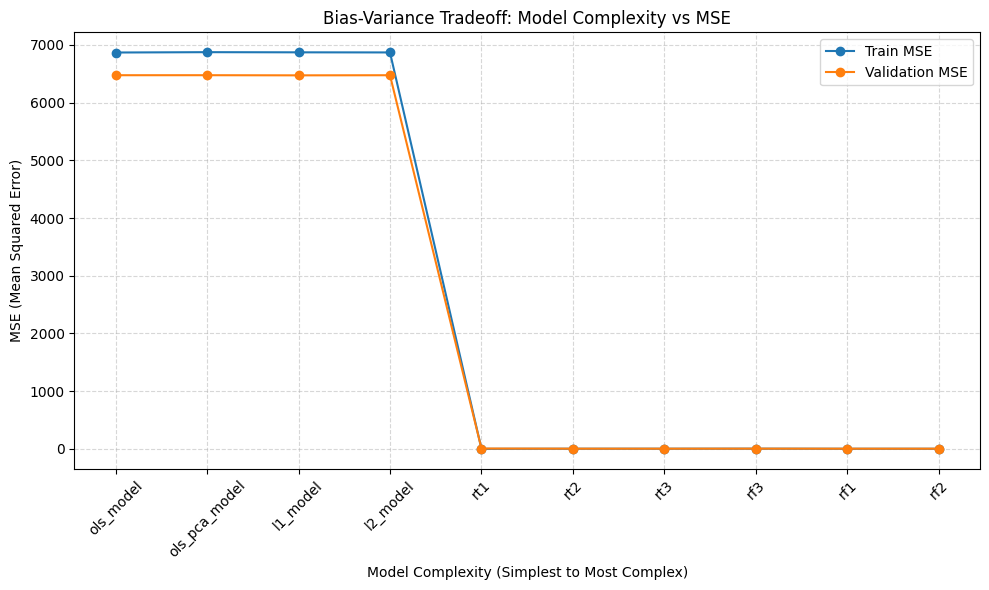

In [14]:
# Sort by model complexity for plotting
df = df.sort_values('model_complexity')

# Plot the Training and Validation MSE vs. Model Complexity
plt.figure(figsize=(10, 6))
plt.plot(df['model_complexity'], df['train_MSE'], marker='o', linestyle='-', label='Train MSE')
plt.plot(df['model_complexity'], df['val_MSE'], marker='o', linestyle='-', label='Validation MSE')

plt.xticks(df['model_complexity'], df['model_name'], rotation=45)
plt.xlabel('Model Complexity (Simplest to Most Complex)')
plt.ylabel('MSE (Mean Squared Error)')
plt.title('Bias-Variance Tradeoff: Model Complexity vs MSE')
plt.legend()
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


There is a big gap between the linear regression models and the tree-based model. To better assess which model performs the best in terms of accuracy and generalization. We want to zoom in the graph for the tree-based methods.

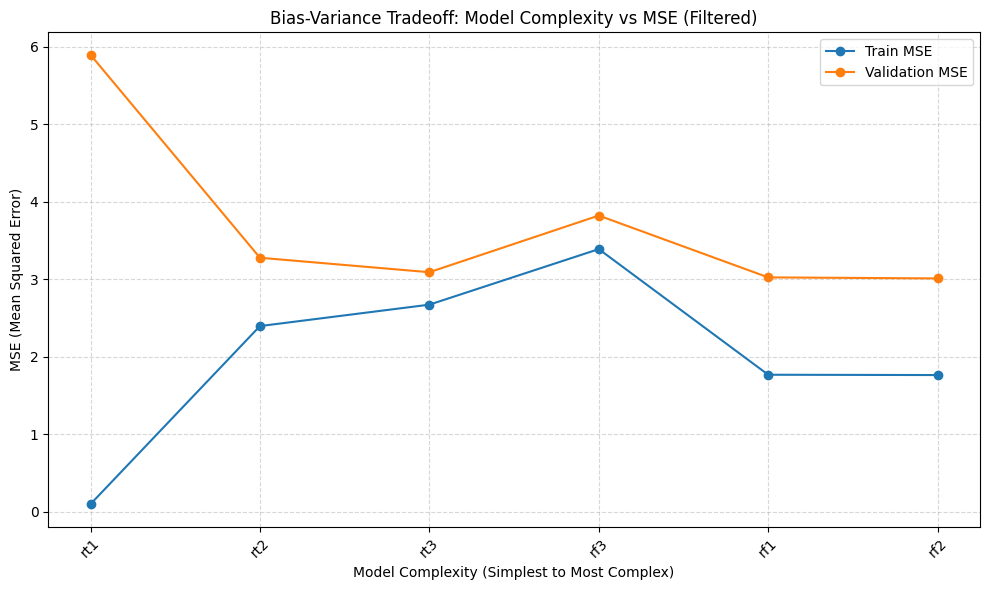

In [15]:
# Filter the DataFrame for model complexity greater than 4
df_filtered = df[df['model_complexity'] > 4]

# Plot the Training and Validation MSE for the filtered data
plt.figure(figsize=(10, 6))
plt.plot(df_filtered['model_complexity'], df_filtered['train_MSE'], marker='o', linestyle='-', label='Train MSE')
plt.plot(df_filtered['model_complexity'], df_filtered['val_MSE'], marker='o', linestyle='-', label='Validation MSE')

plt.xticks(df_filtered['model_complexity'], df_filtered['model_name'], rotation=45)
plt.xlabel('Model Complexity (Simplest to Most Complex)')
plt.ylabel('MSE (Mean Squared Error)')
plt.title('Bias-Variance Tradeoff: Model Complexity vs MSE (Filtered)')
plt.legend()
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


We selected regressoin tree 3, which is a pruned decision tree, as the winning model. The pruned decision tree shows a smaller gap between training and validation RMSE, indicating low variance. In addition, it also has lower biases in comparison to another strong model random forest 3. The Bias and Varaince Chart showed that the regression tree 3 has a good balance with lower variance and a solid generalization capability.

### Winning model performance on the test dataset

In [16]:
winning_mode = models['rt3']
y_train_pred_tree = winning_mode.predict(X_train_scaled)
y_test_pred_tree = winning_mode.predict(X_test_scaled)
y_val_pred_tree = winning_mode.predict(X_val_scaled)

# Evaluate performance
train_mse_tree, train_rmse_tree, train_r2_tree = evaluate_model(y_train, y_train_pred_tree)
val_mse_tree, val_rmse_tree, val_r2_tree = evaluate_model(y_val, y_val_pred_tree)
test_mse_tree, test_rmse_tree, test_r2_tree = evaluate_model(y_test, y_test_pred_tree)

# Print training metrics
print("Decision Tree Regression Model - Training Metrics:")
print(f"MSE: {train_mse_tree:.4f}, RMSE: {train_rmse_tree:.4f}, R²: {train_r2_tree:.4f}")

# Print validation metrics
print("\nDecision Tree Regression Model - Validation Metrics:") 
print(f"MSE: {val_mse_tree:.4f}, RMSE: {val_rmse_tree:.4f}, R²: {val_r2_tree:.4f}")

# Print testing metrics
print("\nDecision Tree Regression Model - Testing Metrics:") 
print(f"MSE: {test_mse_tree:.4f}, RMSE: {test_rmse_tree:.4f}, R²: {test_r2_tree:.4f}")

Decision Tree Regression Model - Training Metrics:
MSE: 2.6747, RMSE: 1.6354, R²: 0.9997

Decision Tree Regression Model - Validation Metrics:
MSE: 3.0933, RMSE: 1.7588, R²: 0.9996

Decision Tree Regression Model - Testing Metrics:
MSE: 3.1037, RMSE: 1.7617, R²: 0.9997
